# 0.1.0 Load Visium Data

See [Space Ranger documentation](https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview) - paraphrased below:

### tissue_positions_list.txt 
This text file contains a table with rows that correspond to spots. It has 4,992 rows, which is the number of spots in the spatial array. Columns, whose names are not specified in the file, correspond to the following fields:

* barcode: The sequence of the barcode associated to the spot.
* in_tissue: Binary, indicating if the spot falls inside (1) or outside (0) of tissue.
* array_row: The row coordinate of the spot in the array from 0 to 77. The array has 78 rows.
* array_col: The column coordinate of the spot in the array. In order to express the orange crate arrangement of the spots, this column index uses even numbers from 0 to 126 for even rows, and odd numbers from 1 to 127 for odd rows. Notice then that each row (even or odd) has 64 spots.
* pxl_col_in_fullres: The column pixel coordinate of the center of the spot in the full resolution image.
* pxl_row_in_fullres: The row pixel coordinate of the center of the spot in the full resolution image.

In [1]:
import sys
import importlib
import himc_helper_functions as hf
importlib.reload(hf)
hf.get_version()

0.12.3 cleaning vdj code


In [2]:
import pandas as pd
from copy import deepcopy
from clustergrammer2 import net

>> clustergrammer2 backend version 0.5.5


In [3]:
import ipywidgets as widgets
import numpy as np
from bqplot import pyplot as plt
import bqplot

from copy import deepcopy
from glob import glob
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import Voronoi

import warnings
warnings.filterwarnings('ignore')

In [4]:
base_dir = '../data/primary/V1_Mouse_Brain_Sagittal_Anterior/'

In [5]:
feat_data = hf.load_crv3_feature_matrix(base_dir + 'filtered_feature_bc_matrix/')

In [6]:
df = hf.convert_to_dense(feat_data)

In [7]:
df = hf.ini_meta_cell(df=df)

In [8]:
df.keys()

dict_keys(['gex', 'meta_cell'])

In [9]:
df['meta_cell'].head()

,gex-umi-sum,num_expressed_genes
AAACAAGTATCTCCCA,13069,4242
AAACACCAATAACTGC,37448,7860
AAACAGAGCGACTCCT,28475,6332
AAACAGCTTTCAGAAG,39718,7957
AAACAGGGTCTATATT,33392,7791


In [10]:
df = hf.filter_ribo_mito_from_gex(df)
df['meta_cell'].head()

,gex-umi-sum,num_expressed_genes,gex-ribo-avg,gex-mito-avg
AAACAAGTATCTCCCA,13069,4242,7.380952,97.600000
AAACACCAATAACTGC,37448,7860,19.809524,256.666667
AAACAGAGCGACTCCT,28475,6332,15.123810,275.533333
AAACAGCTTTCAGAAG,39718,7957,27.676190,184.400000
AAACAGGGTCTATATT,33392,7791,23.447619,117.600000


In [11]:
df['gex'].shape

(30933, 2696)

In [12]:
df.keys()

dict_keys(['gex', 'meta_cell', 'gex-mr'])

### Load Spatial Data

In [13]:
cols = ['in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres']
df_pos = pd.read_csv(base_dir + 'spatial/tissue_positions_list.csv', header=None, index_col=0)
df_pos.columns = cols
df_pos.index.name = None
df_pos.index = [x.split('-')[0] for x in df_pos.index.tolist()]
print(df_pos.shape)

(4992, 5)


#### Keep beads in tissue only

In [14]:
df_pos = deepcopy(df_pos[df_pos['in_tissue'] == 1])
df_pos.shape

(2696, 5)

In [15]:
rows_pos = df_pos.index.tolist()
rows_gex = df['meta_cell'].index.tolist()
print(len(rows_pos))
print(len(rows_gex))

2696
2696


In [16]:
df_meta = pd.concat([df['meta_cell'], df_pos], axis=1)
df_meta.shape

(2696, 9)

In [17]:
df_meta.head()

,gex-umi-sum,num_expressed_genes,gex-ribo-avg,gex-mito-avg,in_tissue,array_row,array_col,pxl_col_in_fullres,pxl_row_in_fullres
AAACAAGTATCTCCCA,13069,4242,7.380952,97.600000,1,50,102,7475,8501
AAACACCAATAACTGC,37448,7860,19.809524,256.666667,1,59,19,8553,2788
AAACAGAGCGACTCCT,28475,6332,15.123810,275.533333,1,14,94,3164,7950
AAACAGCTTTCAGAAG,39718,7957,27.676190,184.400000,1,43,9,6637,2099
AAACAGGGTCTATATT,33392,7791,23.447619,117.600000,1,47,13,7116,2375


#### Define Position in Preferred Coordinate System

In [18]:
df_meta['pos-x'] = df_meta['pxl_row_in_fullres'].apply(lambda x: x)
df_meta['pos-y'] = df_meta['pxl_col_in_fullres'].apply(lambda x: df_meta['pxl_col_in_fullres'].max() - x)

In [19]:
df_meta.head()

,gex-umi-sum,num_expressed_genes,gex-ribo-avg,gex-mito-avg,in_tissue,array_row,array_col,pxl_col_in_fullres,pxl_row_in_fullres,pos-x,pos-y
AAACAAGTATCTCCCA,13069,4242,7.380952,97.600000,1,50,102,7475,8501,8501,2994
AAACACCAATAACTGC,37448,7860,19.809524,256.666667,1,59,19,8553,2788,2788,1916
AAACAGAGCGACTCCT,28475,6332,15.123810,275.533333,1,14,94,3164,7950,7950,7305
AAACAGCTTTCAGAAG,39718,7957,27.676190,184.400000,1,43,9,6637,2099,2099,3832
AAACAGGGTCTATATT,33392,7791,23.447619,117.600000,1,47,13,7116,2375,2375,3353


### Color by UMI

In [20]:
max_umi = df_meta['gex-umi-sum'].max()
mean_umi = df_meta['gex-umi-sum'].mean()
print(max_umi, mean_umi)

67119 24269.346439169138


In [21]:
df_meta['gex-umi-sum-norm'] = df_meta['gex-umi-sum'].apply(lambda x: x - mean_umi )

In [22]:
ser_color = df_meta['gex-umi-sum'].apply(lambda x: (0, 0, 1, x/max_umi) )
list_colors = list(ser_color.get_values())
list_colors[0]

(0, 0, 1, 0.19471386641636496)

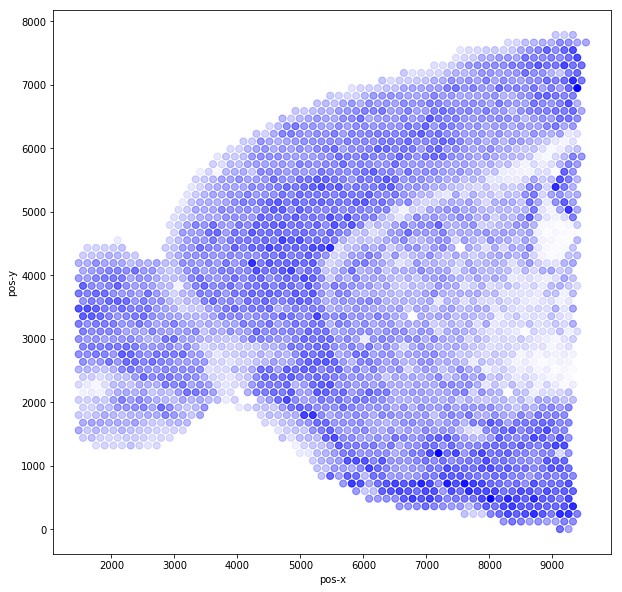

In [23]:
df_meta.plot(kind='scatter', 
             x='pos-x', 
             y='pos-y', 
            figsize=(10,10), 
             c=list_colors, 
            s=50)

### Save Metadata

In [38]:
df_meta.shape

(2696, 12)

In [39]:
df_meta.to_csv('../data/processed/df_meta.csv')

In [40]:
net.load_df(df['gex-cat'])
net.filter_N_top(inst_rc='row', N_top=250, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
net.clip(-5,5)
net.widget()

ExampleWidget(network='{"row_nodes": [{"name": "Bc1", "ini": 250, "clust": 48, "rank": 203, "rankvar": 217, "g…

In [41]:
net.save_dict_to_json(inst_dict=net.viz, filename='../data/processed/pre-calc-viz.json', indent=False)

In [24]:
x_dim = 1200
y_dim = 1000

def_tt = bqplot.Tooltip(fields=['name'], formats=[''])

fig = plt.figure()
# patch = plt.plot([], [], 
#                  fill='inside',
#                  fill_colors=patch_data['colors'],
#                  stroke_width=1,
#                  close_path=True,
#                  labels=region_labels,
#                  tooltip=def_tt,
#                  axes_options={'x': {'visible': False}, 'y': {'visible': False}},
#                 )

scatter = plt.scatter(df_meta['pos-x'], 
                      df_meta['pos-x'],
#                       tooltip=def_tt, 
#                       names=point_names,
                      display_names=False, default_size=20)


scatter.default_size = 250
scatter.default_opacities = [0.1]*5164

top_margin = 275
inst_width = 800
inst_height = inst_width/1.15 + top_margin
fig.layout.min_height = str(inst_height) + 'px'
fig.layout.min_width  = str(inst_width) + 'px'

# patch.x = patch_data['x']
# patch.y = patch_data['y']

plt.xlim(0, 2.0*x_dim)
plt.ylim(0, 2.0*y_dim)
fig.title = 'Codex Cell Locations'
fig.fig_margin = {'top': top_margin, 'bottom': 5, 'left': 5, 'right': 5}

# fig.margin {top=10, bottom=10, left=10, right=10}

# plt.show()

In [25]:
df_meta.columns.tolist()

['gex-umi-sum',
 'num_expressed_genes',
 'gex-ribo-avg',
 'gex-mito-avg',
 'in_tissue',
 'array_row',
 'array_col',
 'pxl_col_in_fullres',
 'pxl_row_in_fullres',
 'pos-x',
 'pos-y',
 'gex-umi-sum-norm']

In [26]:
df['gex-cat'] = deepcopy(net.umi_norm(df['gex']))
cols = df['gex-cat'].columns

add_cat_list = ['gex-umi-sum-norm']

new_cols = hf.add_cats_from_meta(add_cat_list=add_cat_list, df_meta=df_meta, barcodes=cols)
df['gex-cat'].columns = new_cols

In [27]:
df['gex'].shape

(30933, 2696)

In [28]:
net.viz.keys()

dict_keys(['row_nodes', 'col_nodes', 'links', 'mat', 'cat_colors'])

In [29]:
hf.make_dir('../data/processed/')

In [30]:
net.save_dict_to_json(inst_dict=net.viz, filename='../data/processed/pre-calc-viz.json', indent=False)

In [31]:
def on_value_change(change):
    print('here')
    
#     if change['new'] == 'null':
#         cat_highlight('reset_cats')            
#     else: 
#         # mousing over category
#         if 'cat-' in change['new']:
#             inst_cat = change['new'].split(' -> ')[1]
#             cat_highlight(inst_cat)       
            
#         # mousing over marker
#         else:
#             inst_marker = change['new'].split(' -> ')[1]
#             ser_opacity = df['tile-lookup'].loc[inst_marker]
            
#             # the patches are not in the same order as the data in the dataframe
#             #list_opacities = [float(x/ser_opacity.max()) for x in list(ser_opacity.get_values())]
            
#             # loop up opacities
#             list_opacities = []
#             rows = ser_opacity.index.tolist()
#             for inst_name in keep_names:
#                 if inst_name in rows:
#                     list_opacities.append( float(ser_opacity[inst_name]/ser_opacity.max())  )
#                 else:
#                     list_opacities.append(0)
                
#             patch.opacities = list_opacities
#             scatter.default_opacities = list_opacities


In [32]:
net.load_df(df['gex-cat'])
net.filter_N_top(inst_rc='row', N_top=250, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
net.clip(-5,5)
net.widget()
net.widget_instance.observe(on_value_change, names='value')

In [33]:
from ipywidgets import HBox
HBox([fig, net.widget_instance])

here
here
here
